## Setup Environment
Attach Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Install torch 

In [3]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-wdvsehvl
  Running command git clone -q https://github.com/facebookresearch/fvcor

'1.11.0+cu102'

Installing Detectron2

In [4]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13917, done.
remote: Total 13917 (delta 0), reused 0 (delta 0), pack-reused 13917
Receiving objects: 100% (13917/13917), 5.70 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (10057/10057), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 2.5 MB/s 
     |████████████████████████████████| 145 kB 27.3 MB/s 
     |████████████████████████████████| 130 kB 60.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 843 kB 8.2 MB/s 
     |████████████████████████████████| 749 kB 48.3 MB/s 
     |████████████████████████████████| 112 kB 55.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=aa4acb9112951c15ca6501ad58c37a093d97c6c540c48583d44fa1bd22bc41d4
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfu

Navigate to detectron repository directory

In [5]:
import os
os.chdir(r'/content/detectron2_repo/')

## Training
Import packages

In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
import os

Dataset Registration 

In [8]:
register_coco_instances("my_dataset_train2", {}, "/content/gdrive/MyDrive/eagleView/trainval/train.json", "/content/gdrive/MyDrive/eagleView/trainval/images")
register_coco_instances("my_dataset_test2", {}, "/content/gdrive/MyDrive/eagleView/trainval/test.json", "/content/gdrive/MyDrive/eagleView/trainval/images")
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_test2") # Data 
dataset_dicts = DatasetCatalog.get("my_dataset_test2")


[03/20 03:20:49 d2.data.datasets.coco]: Loaded 448 images in COCO format from /content/gdrive/MyDrive/eagleView/trainval/test.json


Plotting some sample data 

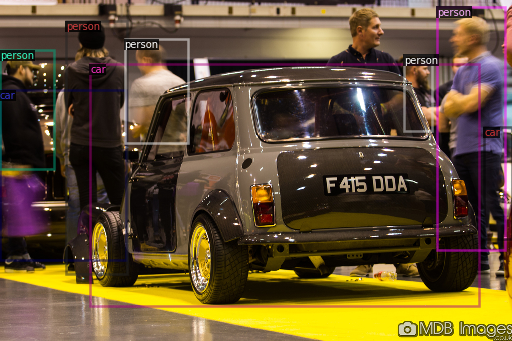

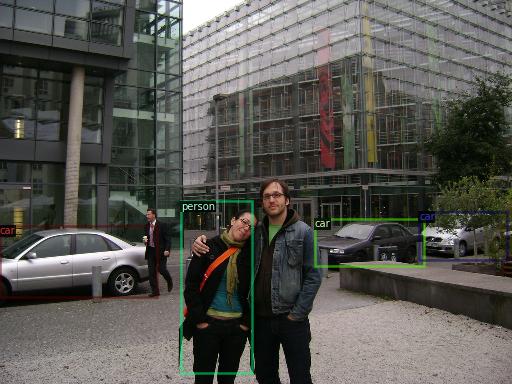

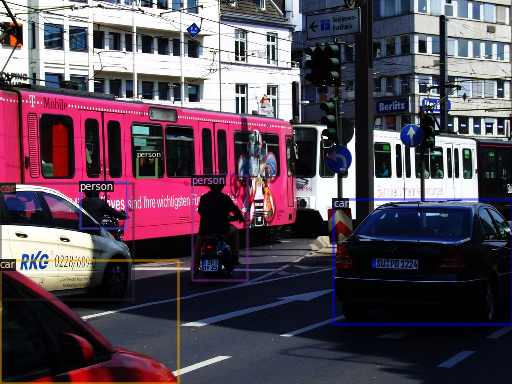

In [9]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Set Configuration (Parameter for training)

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train2",)
cfg.DATASETS.TEST = ("my_dataset_test2",)

cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.OUTPUT_DIR = r'/content/gdrive/MyDrive/eagleView'
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (600, 900)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 500

Training

In [14]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/20 03:22:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/20 03:22:53 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/20 03:24:02 d2.utils.events]:  eta: 0:55:08  iter: 19  total_loss: 2.167  loss_cls: 1.125  loss_box_reg: 0.9584  loss_rpn_cls: 0.03962  loss_rpn_loc: 0.04219  time: 3.3657  data_time: 0.7328  lr: 3.8962e-05  max_mem: 11303M
[03/20 03:25:14 d2.utils.events]:  eta: 0:55:38  iter: 39  total_loss: 1.916  loss_cls: 0.8812  loss_box_reg: 0.9217  loss_rpn_cls: 0.04058  loss_rpn_loc: 0.04866  time: 3.4972  data_time: 0.6905  lr: 7.8922e-05  max_mem: 11423M
[03/20 03:26:26 d2.utils.events]:  eta: 0:54:16  iter: 59  total_loss: 1.594  loss_cls: 0.6411  loss_box_reg: 0.8744  loss_rpn_cls: 0.02715  loss_rpn_loc: 0.04664  time: 3.5239  data_time: 0.6015  lr: 0.00011888  max_mem: 11423M
[03/20 03:27:39 d2.utils.events]:  eta: 0:53:45  iter: 79  total_loss: 1.537  loss_cls: 0.5463  loss_box_reg: 0.9218  loss_rpn_cls: 0.03237  loss_rpn_loc: 0.04632  time: 3.5634  data_time: 0.7023  lr: 0.00015884  max_mem: 11423M
[03/20 03:28:52 d2.utils.events]:  eta: 0:53:31  iter: 99  total_loss: 1.433  loss_cl

Evaluate Model

In [15]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
val_loader = build_detection_test_loader(cfg, "my_dataset_test2")
evaluator = COCOEvaluator("my_dataset_test2", cfg, False, output_dir="./output/")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/20 04:19:13 d2.data.datasets.coco]: Loaded 448 images in COCO format from /content/gdrive/MyDrive/eagleView/trainval/test.json
[03/20 04:19:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/20 04:19:13 d2.data.common]: Serializing 448 elements to byte tensors and concatenating them all ...
[03/20 04:19:13 d2.data.common]: Serialized dataset takes 0.20 MiB
[03/20 04:19:13 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/20 04:19:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/20 04:19:13 d2.evaluation.evaluator]: Start inference on 448 batches
[03/20 04:19:17 d2.evaluation.evaluator]: Inference done 11/448. Dataloading: 0.0018 s/iter. Inference: 0.2723 s/iter. Eval: 0.0003 s/iter. Total: 0.2744 s/iter. 

OrderedDict([('bbox',
              {'AP': 43.50784587269876,
               'AP-car': 49.02160130922347,
               'AP-person': 37.99409043617405,
               'AP50': 73.48617056290915,
               'AP75': 44.330113971145856,
               'APl': nan,
               'APm': nan,
               'APs': 55.672873777908})])

Prediction 

Set Config 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test2", )
predictor = DefaultPredictor(cfg)

Prediction

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in dataset_dicts:   
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs )
    v = Visualizer(im,
                   metadata=my_dataset_train_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image())
    cv2.imwrite(os.path.join(r'/content/gdrive/MyDrive/eagleView/trainval/prediction',os.path.basename( d["file_name"])),v.get_image()[:, :, ::-1] )

Mapping result to calculate False Positive

In [129]:
for d in dataset_dicts:   
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    fields = outputs["instances"].to("cpu").get_fields()
    pred_boxes = fields['pred_boxes'].tensor.numpy()
    pred_classes  = fields['pred_classes'].numpy()
    scores = fields['scores'].numpy()d
    str1 =''


    for idx in range(0,pred_boxes.shape[0]):
      predClass = ''
      
      if pred_classes[idx] == 0 : 
        predClass = 'person'
      else :
        predClass = 'car'
      
      str1 +=  str(predClass)+' '+ str(scores[idx])+  ' '+str(pred_boxes[idx][0])+ ' '+str(pred_boxes[idx][1])+ ' '+ str(pred_boxes[idx][2])+ ' '+str(pred_boxes[idx][3]) +'\n'
    print(str1)
    with open(os.path.join('/content/gdrive/MyDrive/eagleView/trainval/vocFiles/',os.path.basename(d["file_name"]).split('.')[0]+'.txt'), 'w+') as fp:
      fp.write(str1)
      fp.close



/content/gdrive/MyDrive/eagleView/trainval/images/image_000000018.jpg
car 0.9909995 0.0 260.5752 635.0287 588.5133
person 0.9671185 714.4176 237.94235 767.4487 397.3807
car 0.9362169 0.0 284.49448 69.3333 322.9202

/content/gdrive/MyDrive/eagleView/trainval/images/image_000000036.jpg
person 0.95046574 575.1307 120.66057 840.28973 660.97345
car 0.9405354 5.3370347 247.29486 867.70807 681.4438
car 0.9258178 853.83405 257.4563 1020.76904 440.39728
car 0.9081851 820.426 435.55713 1022.7339 677.72864

/content/gdrive/MyDrive/eagleView/trainval/images/image_000000040.jpg
person 0.95318764 719.6195 415.21536 757.7713 525.7067
car 0.88937676 636.77295 436.2597 706.0598 516.1404

/content/gdrive/MyDrive/eagleView/trainval/images/image_000000042.jpg
car 0.99324715 245.89742 368.77155 967.13 647.7372
person 0.9557234 184.9315 204.9044 247.83562 402.85757
person 0.94513404 135.47119 282.02158 193.98267 482.3841
person 0.9253638 150.12625 223.84814 197.58443 360.66153
person 0.891211 516.1028 300.2

In [20]:
# cfg.MODEL.WEIGHTS = os.path.join('/content/gdrive/MyDrive/eagleView/model_final.pth')
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
# cfg.DATASETS.TEST = ("my_dataset_test2", )
# cfg.MODEL.DEVICE = "cpu"
# predictor = DefaultPredictor(cfg)

model_final_68b088.pkl: 421MB [00:09, 44.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

In [28]:
!pip freeze  > Requirement.txt